# Lending Tree Data

Use random forest classifiers on the cleaned Lending Tree Data.

Last updated 2016.04.28 by Stinnett

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display plots inline, use a nicer style.
%matplotlib inline
plt.style.use('ggplot')

# Notebook options
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

In [2]:
# Import data
filename='../Data/LendingClub/LC_Data_cleaned.csv'
data=pd.read_csv(filename,delimiter=',',low_memory=False)

First, just go get a feel for the grading, let's look the interest rate vs grade.

# Prepare data

Prepare a training and test data set.

In [3]:
def regularize_data(trainingdata,testdata,column):
    shift=trainingdata[column].mean()
    scale=trainingdata[column].std()
    
    trainingdata[column]=(trainingdata[column]-shift)/scale
    testdata    [column]=(testdata    [column]-shift)/scale
    return None


In [4]:

#cols=['grade_n','loan_amnt','term','home_ownership','dti','int_rate','annual_inc','tot_hi_cred_lim','loan_status']
scheme_data=data

#drop na values
scheme_data=scheme_data.dropna(how='any',axis=0) # removes about 70k of 880k entries

print('NaN rows removed: '+str(data.shape[0]-scheme_data.shape[0]))
print('Rows remaining: '+str(scheme_data.shape[0]))

scheme_data.head(3)
scheme_data=scheme_data.drop('Unnamed: 0',1)
scheme_data=scheme_data.drop('good_loan',1)
scheme_data.head(3)

NaN rows removed: 521
Rows remaining: 886880


,loan_amnt,dti,grade_n,term,int_rate,...,home_none,home_other,verified_incsource,verified_inc,bad_loan
0,5000,27.65,1,0,0.1065,...,0,0,0,1,False
1,2500,1.00,2,1,0.1527,...,0,0,1,0,True
2,2400,8.72,2,0,0.1596,...,0,0,0,0,False


In [5]:
cols=scheme_data.columns
cols=cols[:-1] #remove bad_loan

In [6]:
#separate into training and test data
# pick n_test values to use as a test set.  use the rest as a training set.
# Make a random list.

x=np.arange(scheme_data.shape[0])
x=np.random.choice(x,size=len(x),replace=False)

n_test=100000
test_data =scheme_data.iloc[x[0:n_test]][cols]
test_label =scheme_data.iloc[x[0:n_test]]['bad_loan'].values*1
train_data=scheme_data.iloc[x[n_test:]][cols]
train_label=scheme_data.iloc[x[n_test:]]['bad_loan'].values*1


for column in train_data.columns:
    regularize_data(train_data,test_data,column)

# Adaboosted Logistic Regression
## Use adaboosted logistic regression and 6-fold crossvalidation on the data.   Generate a ROC curve.

Follows the example from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#example-model-selection-plot-roc-crossval-py

Last updated May 1, 2016

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier   

# Adaboost LogReg

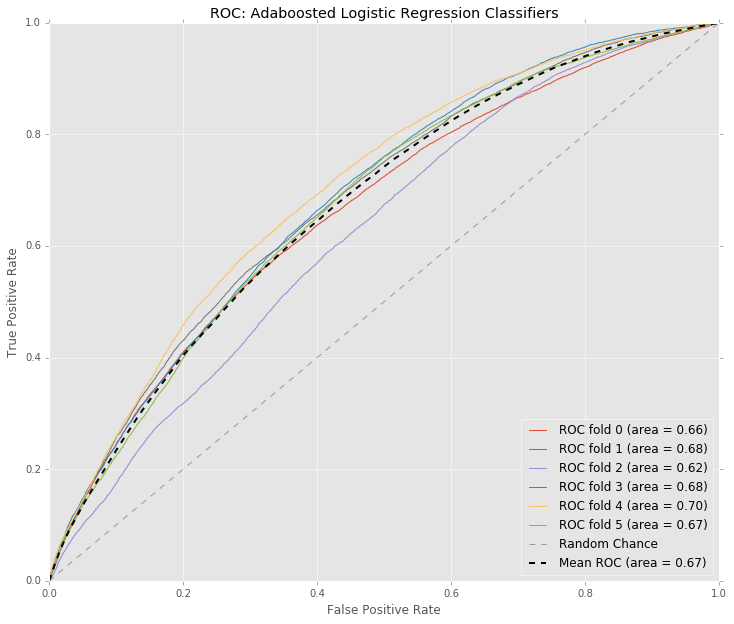

In [24]:
# Use a subset of the data for now
nrows=800000
X =scheme_data.iloc[0:nrows][cols].values
y =scheme_data.iloc[0:nrows]['bad_loan'].values*1

# Run classifier with 6-fold cross-validation
cv = StratifiedKFold(y, n_folds=6)

# Define the classifier
# Logistic regression options
log_solver='lbfgs' #could use lbfgs
log_multi='multinomial'

clf_base=linear_model.LogisticRegression(
    C=1,
    multi_class=log_multi,
    solver=log_solver,
    class_weight={0: 1, 1:20}
    )
        
from sklearn.ensemble import AdaBoostClassifier         
classifier = AdaBoostClassifier(
    base_estimator=clf_base,
    n_estimators = 400,
    learning_rate=1.0
    )
       
#Run
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
plt.figure(figsize=(12,10)) 
for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Adaboosted Logistic Regression Classifiers')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classifier.fit(X[train], y[train]).predict_proba(X[test])